# URL Classification

+ https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/
+ https://towardsdatascience.com/naive-bayes-classifier-from-scratch-with-python-942708211470
+ https://scikit-learn.org/stable/modules/naive_bayes.html
+ https://github.com/japborst/dart_stemmer/blob/master/lib/PorterStemmer.dart
+ https://tartarus.org/martin/PorterStemmer/
+ https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls
+ https://www.kaggle.com/datasets/akashkr/phishing-website-dataset
+ https://www.kaggle.com/datasets/sandunabeysooriya/phishing-detection-dataset
+ https://www.youtube.com/watch?v=O2L2Uv9pdDA
+ https://www.kaggle.com/code/tylersullivan/classifying-phishing-urls-three-models
+ https://towardsdatascience.com/how-i-was-using-naive-bayes-incorrectly-till-now-part-1-4ed2a7e2212b
+ https://towardsdatascience.com/why-how-to-use-the-naive-bayes-algorithms-in-a-regulated-industry-with-sklearn-python-code-dbd8304ab2cf
+ https://towardsdatascience.com/all-you-need-to-know-about-bag-of-words-and-word2vec-text-feature-extraction-e386d9ed84aa
+ https://towardsdatascience.com/text-normalization-7ecc8e084e31
+ https://medium.com/analytics-vidhya/how-to-build-a-lemmatizer-7aeff7a1208c

In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB

import matplotlib.pyplot as plt
%matplotlib inline

## Data Import and Cleaning

__Features of interest:__
+ Length
+ Number of dots
+ Number of sub-paths `/`
+ Usage of shortening services
+ Usage of symbols, such as `@`, `?`, `//`
+ Using `http` or `https`
+ Domain (`.gov`, `.com`, etc.)
+ Is IP address

In [3]:
data = pd.read_csv("./data/phishing_site_urls.csv", encoding="utf-8")
data["Label"].replace(to_replace="bad", value=1, inplace=True)
data["Label"].replace(to_replace="good", value=0, inplace=True)

print(data)
# print(data.info())

                                                      URL  Label
0       nobell.it/70ffb52d079109dca5664cce6f317373782/...      1
1       www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...      1
2       serviciosbys.com/paypal.cgi.bin.get-into.herf....      1
3       mail.printakid.com/www.online.americanexpress....      1
4       thewhiskeydregs.com/wp-content/themes/widescre...      1
...                                                   ...    ...
549243                                    23.227.196.215/      1
549244                                 apple-checker.org/      1
549245                                  apple-iclods.org/      1
549246                                 apple-uptoday.org/      1
549247                                  apple-search.info      1

[549248 rows x 2 columns]


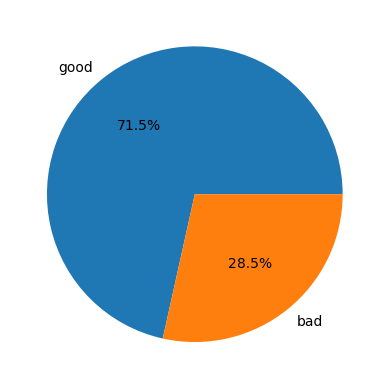

In [4]:
sizes = [data[data["Label"] == 0].shape[0]
        ,data[data["Label"] == 1].shape[0]
        ]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=["good", "bad"], autopct='%1.1f%%')
plt.show()

In [24]:
import re
from collections import Counter

ip_re = re.compile(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}(:\d{1,5})?$")
url_re = re.compile(r"(https?://)?([^/]+)(/.*)?")
hexa_re = re.compile(r"^[0-9a-f]+$")
split_re = re.compile(r"[^\w\d]")

#----------------------------#

vowels = {'a','e','i','o','u','y'}

# (assumes lowercase and w.isalpha() is True)
def readable(w: str) -> bool:
    tl, nb = 0, 0
    i, cs  = 0, 1
    while i < len(w):
        cs = 1
        v  = w[i] in vowels
        i += 1
        while i < len(w) and (w[i] in vowels) == v:
            cs += 1
            i  += 1
        if cs > 2:
           nb += 1
        tl += 1
    return (nb / tl) < 0.2

#----------------------------#
    
# Remove parsing artifacts (won't be needed for the real thing)
def cleanURL(url: str) -> str:
    s, e = 0, -1
    qs = ["'", '"']
    if url[0] in qs:
        s = 1
    if url[-1] in qs:
        e = -2
    return url[s:e]

#----------------------------#

# Split the URL into its smaller parts
def splitURL(url: str) -> tuple:
    match = url_re.match(url)
    return match.group(2,3) if match != None else None

#----------------------------#

def normalize(w: str) -> str:
    if w.isdigit():
        return '{{num}}'
    # if not w.isalpha() and hexa_re.match(w) != None:
    #     return '{{id}}'
    if not w.isalpha():
        return '{{other}}'
    if len(w) > 4 and not readable(w):
        return '{{jnk}}'
    if len(w) > 15:
        return '{{lword}}'
    return '{{word}}'

#----------------------------#

# Extract properties and features from URL
def processURL(url: str) -> list:
    curl = cleanURL(url)
    (a, p) = splitURL(curl)
    ts = Counter([normalize(t.lower()) for t in split_re.split(a)])
    return [ p.count('%') if p != None else 0
           , curl.count('.')
           , p.count('/') if p != None else 0
           , p.count('//') if p != None else 0
           , curl.count(':')
           , p.count('?') if p != None else 0
           , p.count('@') if p != None else 0
           , int(ip_re.search(a) != None)
           , len(a)
           , len(p) if p != None else 0
           # , len(split_re.split(p)) if p != None else 0
           # , ts['{{id}}']
           , ts['{{jnk}}']
           , ts['{{lword}}']
           , ts['{{num}}']
           , ts['{{other}}']
           , ts['{{word}}']
           ]

#==========================================#

# cs = ['%','.','/','//',':','?','@','ip','len','sub','{{id}}','{{jnk}}','{{lword}}','{{num}}','{{other}}','{{word}}']
# cs = ['%','.','/','//',':','?','@','ip','lenA','lenP','sub','{{jnk}}','{{lword}}','{{num}}','{{other}}','{{word}}']
cs = ['%','.','/','//',':','?','@','ip','lenA','lenP','{{jnk}}','{{lword}}','{{num}}','{{other}}','{{word}}']
vs = pd.DataFrame(data["URL"].map(processURL).to_list(), columns=cs)
        
print(vs.sample(10))

        %  .  /  //  :  ?  @  ip  lenA  lenP  {{jnk}}  {{lword}}  {{num}}  \
476777  0  1  1   0  0  1  0   0    11    19        1          0        0   
120335  0  1  1   0  0  0  0   0    12     3        0          0        0   
30552   0  3  5   0  0  0  0   0    30    48        0          1        0   
457028  0  1  2   0  0  0  0   0    14    12        0          0        0   
141719  0  3  0   0  0  0  0   0    30     0        1          1        0   
149415  0  3  4   0  0  0  0   0    13    15        0          0        0   
318681  0  2  2   0  0  1  0   0     8    28        0          0        0   
145283  0  2  3   0  0  0  0   0    19    67        1          0        0   
456669  0  2  3   0  0  0  0   0     9    25        1          0        0   
135429  0  1  4   0  0  0  0   0    15    33        0          0        0   

        {{other}}  {{word}}  
476777          0         1  
120335          0         2  
30552           0         2  
457028          0         2  
14

## Training and Testing



In [25]:
trainX, testX, trainY, testY = train_test_split(vs, data.Label, test_size=0.3, random_state=0)

In [26]:
mnb = MultinomialNB()
mnb.fit(trainX, trainY)

pred = mnb.predict(testX)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

              precision    recall  f1-score   support

        good       0.75      0.90      0.82    118073
         bad       0.50      0.26      0.35     46702

    accuracy                           0.72    164775
   macro avg       0.63      0.58      0.58    164775
weighted avg       0.68      0.72      0.69    164775



In [27]:
cnb = ComplementNB()
cnb.fit(trainX, trainY)

pred = cnb.predict(testX)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

              precision    recall  f1-score   support

        good       0.75      0.75      0.75    118073
         bad       0.37      0.37      0.37     46702

    accuracy                           0.64    164775
   macro avg       0.56      0.56      0.56    164775
weighted avg       0.64      0.64      0.64    164775



In [28]:
dt = DecisionTreeClassifier(random_state=0, max_depth=len(cs))
dt.fit(trainX, trainY)

pred = dt.predict(testX)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

              precision    recall  f1-score   support

        good       0.85      0.95      0.90    118073
         bad       0.82      0.58      0.68     46702

    accuracy                           0.84    164775
   macro avg       0.84      0.77      0.79    164775
weighted avg       0.84      0.84      0.84    164775



In [35]:
svm = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=0, max_iter=5, tol=None)
svm.fit(trainX, trainY)

pred = svm.predict(testX)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

              precision    recall  f1-score   support

        good       0.75      0.99      0.85    118073
         bad       0.80      0.15      0.25     46702

    accuracy                           0.75    164775
   macro avg       0.77      0.57      0.55    164775
weighted avg       0.76      0.75      0.68    164775



---
## Post-Processing

+ Code generation
+ Other statistics

In [40]:
# Remove redundant branches
# https://stackoverflow.com/a/68660641

from sklearn.tree._tree import TREE_LEAF, TREE_UNDEFINED

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        inner_tree.feature[index] = TREE_UNDEFINED
        ##print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)
    
prune_duplicate_leaves(dt)

print(dt.tree_.node_count)

7747


In [131]:
# r = export_text(dt, feature_names=cs)
# print(r)

# import graphviz

# dot_data = export_graphviz(dt, out_file=None, 
#                      feature_names=cs,  
#                      class_names=['good','bad'],  
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph.render('url')

In [34]:
# Generate Flutter code
fs = ""
rs = []

fts = dt.tree_.feature
trh = dt.tree_.threshold
left  = dt.tree_.children_left
right = dt.tree_.children_right
val = dt.tree_.value

for i in range(0, dt.tree_.node_count):
    if left[i] != right[i]:
        lf = str(bool(val[left[i]][0].argmax())).lower() if left[left[i]] == right[left[i]] else '_check{0}'.format(left[i])
        rh = str(bool(val[right[i]][0].argmax())).lower() if left[right[i]] == right[right[i]] else '_check{0}'.format(right[i])
        if lf == rh:
            fs += '  final _check{0} = {1};\n'.format(i, lf)
        elif lf == 'true' and rh == 'false':
            fs += '  bool get _check{0} => _vector[{1}] <= {2};\n'.format(i, fts[i], trh[i])
        elif lf == 'false' and rh == 'true':
            # fs += '  bool get _check{0} => !(_vector[{1}] <= {2});\n'.format(i, fts[i], trh[i])
            fs += '  bool get _check{0} => _vector[{1}] > {2};\n'.format(i, fts[i], trh[i])
        else:
            fs += '  bool get _check{0} => (_vector[{1}] <= {2}) ? {3} : {4};\n'.format(i, fts[i], trh[i], lf, rh)

# Generate code
with open("../lib/utils/url_decision_tree.dart", "w") as f:
    f.writelines([
        "import 'package:spam_chat/models/transformer.dart';\n\n",
        '//=================================================//\n\n',
        '/// A Decision Tree encoded as a class with each nodes being a function. Used for URL classification.\n',
        '///\n',
        '/// (Code generated by python script `model/url.ipynb`)\n',
        'class UrlDecisionTree {\n',
            '  UrlDecisionTree(this.transformer);\n\n',
            # '  final int featureLength;\n',
            '  final Transformer<double, String> transformer;\n\n',
            '  static const featureCount = {0};\n\n'.format(len(cs)),
            '  List<double> _vector = [];\n\n'
            '  //----------------------------//\n\n',
            '  bool predict(String url) {\n',
                '    _vector = transformer.transform(url);\n',
                '    assert(_vector.length == featureCount);\n',
                '    return _check0;\n',
            '  }\n\n',
            '  //----------------------------//\n\n',
            fs,
        '}',
    ])

In [58]:
values = mnb.feature_log_prob_
cnt = ""

# Generate Code for the Flutter App
for i, n in enumerate(cs):
    cnt += "  Vec2({0}, {1}),\n".format(values[0][i], values[1][i])
    
with open("../lib/utils/url_vocabulary.dart", "w") as f:
    f.writelines([
        "part of 'url_filter.dart';\n\n",
        '//=================================================//\n\n',
        '/// Contains the log likelihoods used to make a multinomial naive bayes prediction.\n',
        '///\n',
        '/// (Code generated by python script `model/url.ipynb`)\n',
        "const logLikelihoods = [\n",
            cnt,
        "];",
    ])